<a href="https://colab.research.google.com/github/RuthKassahun/Skin-Lesion-Classification/blob/main/Multi_Class_Hu_Moments_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HU moments Multi class

## Import Libraries

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix


## Load Data

In [3]:
print(os.listdir("/content/drive/MyDrive/train/sample_train"))
SIZE = 224

['other', 'nevus']


In [5]:
def extract_hu_moments(img):
   
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(gray)).flatten()
    return feature

In [6]:
train_images = []
train_labels = [] 
hu_features = []
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/Multiclass/multi_train/*"):
    label = directory_path.split("/")[-1]
    #print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path)[:, :, :3] #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        train_images.append(img)
        train_labels.append(label)
        hu_feature = extract_hu_moments(img)
        hu_features.append(hu_feature)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
print(train_labels)

['scc' 'scc' 'scc' ... 'bcc' 'bcc' 'bcc']


In [8]:
test_images = []
test_labels = []
hu_features_test = []

#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/drive/MyDrive/Multiclass/multi_val/*"):
    test_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path)[:, :, :3]
        img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        test_labels.append(test_label)
        hu_feature_test = extract_hu_moments(img)
        hu_features_test.append(hu_feature_test)
        
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)


## Label Encoding

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
x_train, y_train, x_test, y_test = hu_features, train_labels_encoded, hu_features_test, test_labels_encoded


In [11]:
X_for_ML = x_train
X_test_ML = x_test


In [12]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [14]:
over=RandomOverSampler(random_state=0,sampling_strategy='minority')
X_res,Y_res=over.fit_resample(x_train,y_train)

In [15]:
print(sum(Y_res==2))

2713


In [16]:
over=RandomOverSampler(random_state=0,sampling_strategy='minority')
X_result,Y_result=over.fit_resample(X_res,Y_res)

In [17]:
print(sum(Y_result==2))

2713


## SVM

In [18]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [19]:
pipe1.fit(X_result,Y_result)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

Accuracy: 33.86%


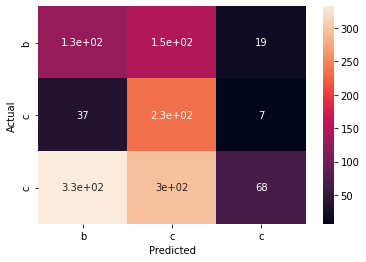

In [20]:
# Test set evaluation
prediction = pipe1.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [21]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.11933694360058111


## Random Forest

In [22]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [23]:
pipe2.fit(X_result,Y_result)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 59.92%


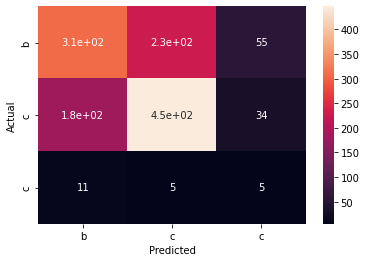

In [24]:
# Test set evaluation
prediction = pipe2.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [25]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.25723655182556915


## KNN

In [26]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [27]:
pipe3.fit(X_result,Y_result)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

Accuracy: 47.32%


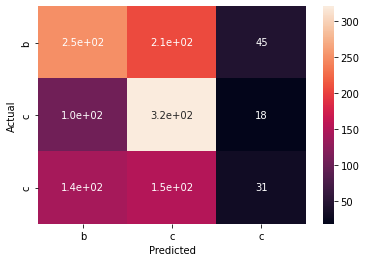

In [28]:
# Test set evaluation
prediction = pipe3.predict(x_test)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [29]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.1770372838539951


## AdaBoost

In [30]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_result,Y_result)

AdaBoostClassifier(n_estimators=200, random_state=0)

Accuracy: 38.50%


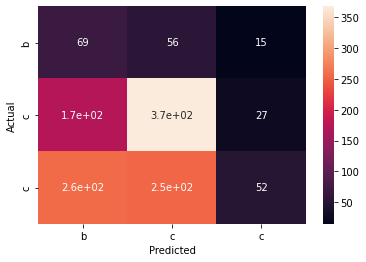

In [31]:
# Test set evaluation
prediction = clf.predict(x_test)
# Visualization
cmat = confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [32]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.10352887159983237


## XGB

In [33]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1,objective='multi:softmax')
train_arr = np.array(X_result)
test_arr = np.array(Y_result)
mod1.fit(train_arr, test_arr)

XGBClassifier(booster='dart', objective='multi:softprob')

In [34]:
prediction = mod1.predict(x_test)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction))

Accuracy =  0.5149606299212598


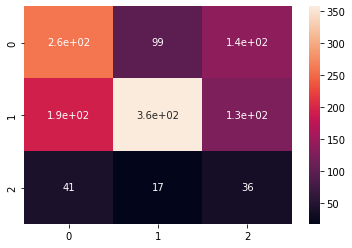

In [35]:
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

In [36]:
kappa = cohen_kappa_score(prediction, test_labels_encoded)
print(kappa)

0.23054831006251442


In [106]:
skf = StratifiedKFold(n_splits = 5)

In [107]:
# Defining a dictionary
model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [0.1, 1, 5, 10, 100], #Regularization parameter.
            'kernel': ['rbf','linear','sigmoid','poly'], 
            'gamma':[0.00001,0.0001,0.001,0.01,0.1,1]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [30,50,70,100] #Trees: may lead to overfitting if n_estimators is too much
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1, 5, 9, 15, 19, 23, 27, 31, 35, 39]
        }
    }
}

In [109]:
scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=skf, n_jobs=6, #five fold cross validation
                         return_train_score=False)
    
    grid.fit(X_result,Y_result)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

           model  best_score                              best_params
0            svm    0.339972  {'C': 10, 'gamma': 1, 'kernel': 'poly'}
1  random_forest    0.652664                    {'n_estimators': 100}
2            KNN    0.745926                       {'n_neighbors': 1}
